In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_c = pd.read_csv("data/customers.csv", delimiter=";")
df_i = pd.read_csv("data/indicators.csv", delimiter=";")

print(f"Same size ? >> {len(df_c)==len(df_i)}")
print(f"Same amount of unique client id ? >> {len(df_c['ID_CLIENT'].unique()) == len(df_i['ID_CLIENT'].unique())}")
print(f"Only unique ID ? >> {len(df_c)==len(df_c['ID_CLIENT'].unique())}")

Same size ? >> True
Same amount of unique client id ? >> True
Only unique ID ? >> True


In [3]:
df = df_c.merge(df_i,on="ID_CLIENT")
df["DATE_ENTREE"]=pd.to_datetime(df["DATE_ENTREE"]) 
df.head()

ID_CLIENT DATE_ENTREE               NOM       PAYS SEXE  AGE MEMBRE_ACTIF  \
0   15688172  2015-01-01               Tai    Espagne    H   40           No   
1   15787258  2014-05-01              Ross    Espagne    F   29           No   
2   15791700  2018-01-01  Ugochukwutubelum  Allemagne    H   47          Yes   
3   15569438  2010-03-01               Mai  Allemagne    H   36           No   
4   15778947  2017-01-01          Sullivan     France    H   36          Yes   

     BALANCE  NB_PRODUITS CARTE_CREDIT    SALAIRE  SCORE_CREDIT CHURN  
0       0.00            2          Yes   88947.56         677.0    No  
1       0.00           16          Yes        NaN           NaN    No  
2  118079.47            4          Yes  143007.49         773.0   Yes  
3  106702.94            2           No  198313.69         607.0    No  
4       0.00            2          Yes    8742.91         628.0    No

In [4]:
import datetime
df = df.assign(delta_date = lambda x: x.DATE_ENTREE - datetime.datetime(year = 2020, month = 6, day = 1))
df = df.assign(delta_date = lambda x: x.delta_date.dt.days)
df = df.assign(Balance_by_product = lambda x: x.BALANCE/x.NB_PRODUITS)

Rows deleted : 559


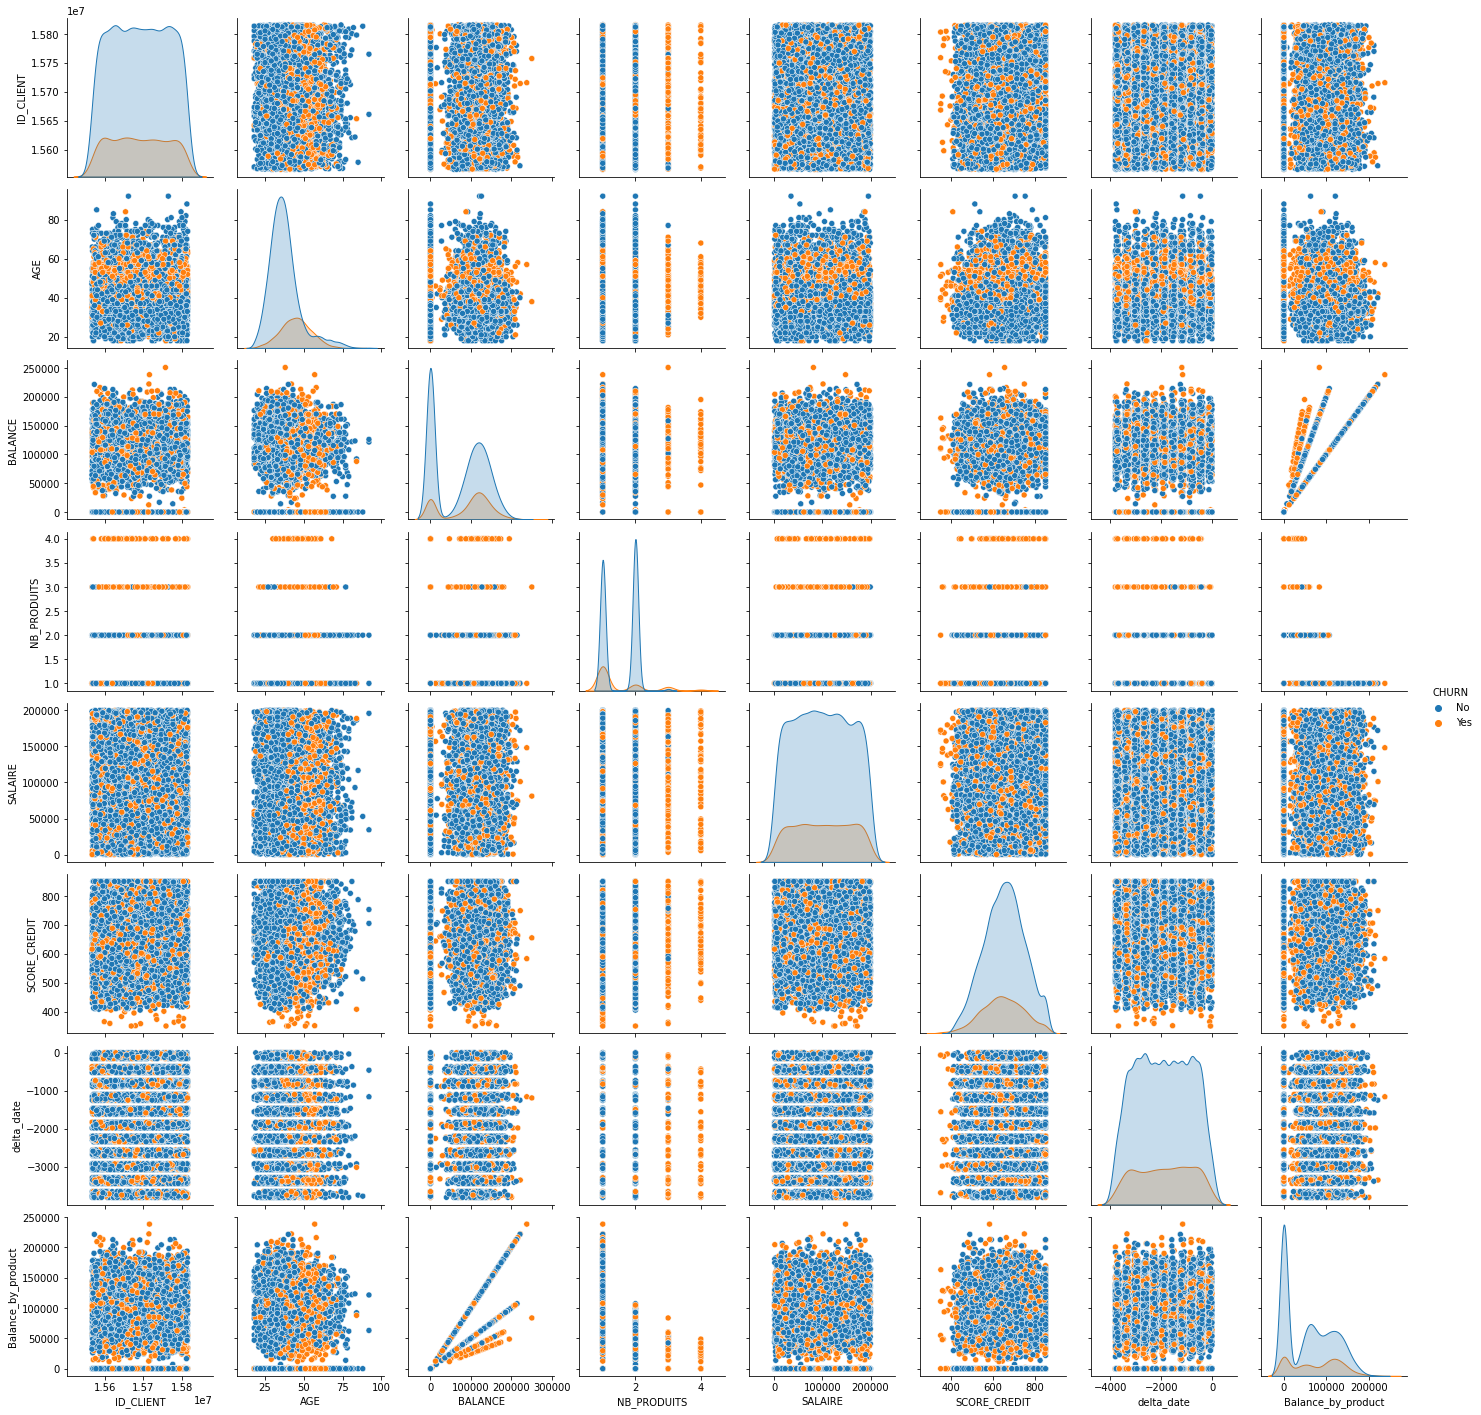

In [5]:
df_pair_plot = df.dropna()
df_pair_plot = df_pair_plot.assign(Balance_by_product = lambda x: x.BALANCE/x.NB_PRODUITS)
print(f"Rows deleted : {len(df)-len(df_pair_plot)}")
sns.pairplot(df_pair_plot, hue="CHURN")


### Select relevant features

In [6]:
df_poc = df_pair_plot[["CHURN","PAYS","SEXE", "AGE", "MEMBRE_ACTIF" , "BALANCE",'SALAIRE', "NB_PRODUITS", "SCORE_CREDIT", 'delta_date', 'Balance_by_product']].dropna()
df_poc = df_poc.assign(Balance_Salaire= lambda x: x.BALANCE/x.SALAIRE)
df_poc = df_poc.assign(SCORE_by_age = lambda x: x.SCORE_CREDIT/x.AGE)
df_poc.head()

CHURN       PAYS SEXE  AGE MEMBRE_ACTIF    BALANCE    SALAIRE  NB_PRODUITS  \
0    No    Espagne    H   40           No       0.00   88947.56            2   
2   Yes  Allemagne    H   47          Yes  118079.47  143007.49            4   
3    No  Allemagne    H   36           No  106702.94  198313.69            2   
4    No     France    H   36          Yes       0.00    8742.91            2   
5    No    Espagne    F   55          Yes  133676.65   17095.49            1   

   SCORE_CREDIT  delta_date  Balance_by_product  Balance_Salaire  SCORE_by_age  
0         677.0       -1978              0.0000         0.000000     16.925000  
2         773.0        -882          29519.8675         0.825687     16.446809  
3         607.0       -3745          53351.4700         0.538051     16.861111  
4         628.0       -1247              0.0000         0.000000     17.444444  
5         645.0        -366         133676.6500         7.819410     11.727273

### Preprocess data

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['AGE', 'BALANCE', 'NB_PRODUITS', "SCORE_CREDIT",'SALAIRE','Balance_Salaire', 'SCORE_by_age', 'delta_date', 'Balance_by_product']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['PAYS', 'SEXE', "MEMBRE_ACTIF"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Train model

In [8]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
X = df_poc.drop("CHURN", axis=1)
y = df_poc["CHURN"].replace(to_replace=["No","Yes"], value=[0,1])


clf = Pipeline( \
               steps=
               [('preprocessor', preprocessor),\
                ('classifier', BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=2000, 
                                 max_samples=1000,
                                 random_state=6,n_jobs=5))])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=10)

clf.fit(X_train,y_train)
score = clf.score(X_test, y_test)
print(f"model accuracy: {round(score*100,1)}%")

model accuracy: 85.5%


## Cross Validation et hyperparamètres

In [9]:
BC_param_grid = {
'classifier__bootstrap': [True, False],
'classifier__bootstrap_features': [True, False],    
'classifier__n_estimators': [50, 500, 1000],
'classifier__max_samples' : [10, 100, 1000],
'classifier__base_estimator__criterion': ['gini', 'entropy']
}

In [10]:
from sklearn.model_selection import GridSearchCV

cv_model = GridSearchCV(clf, param_grid=BC_param_grid, cv=3, n_jobs = -1)
cv_model.fit(X_train, y_train)

print(("best bagging from grid search: %.3f"
       % cv_model.score(X_test, y_test)))
    

best SVM from grid search: 0.855


## Métriques et seuils

In [81]:
y_prev_train = cv_model.predict_proba(X_train)
y_prev_test = cv_model.predict_proba(X_test)

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_train, y_prev_train[:,1])

In [77]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train, y_prev_train[:,1])
disp = plot_precision_recall_curve(clf, X_train, y_train)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AUC={0:0.2f}'.format(auc(recall, precision)))

Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.88')

In [82]:
#optimal_idx = np.argmax(precision + 5*np.sqrt(recall))
optimal_idx = np.argmax(precision + 0.5*np.sqrt(recall))
optimal_threshold = thresholds[optimal_idx]


In [83]:
optimal_threshold

0.604

In [84]:
recall[optimal_idx]

0.3934169278996865

In [85]:
y_pre_test = y_prev_test

In [86]:
for i in range(0,len(y_pre_test[:,1])):
    if y_pre_test[i,1] > optimal_threshold:
        y_pre_test[i,1] = 1
    else:
        y_pre_test[i,1] = 0

In [87]:
from sklearn.metrics import log_loss, classification_report
print(classification_report(y_test, y_pre_test[:,1]))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2465
           1       0.88      0.30      0.45       635

    accuracy                           0.85      3100
   macro avg       0.86      0.65      0.68      3100
weighted avg       0.85      0.85      0.82      3100

